In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest,
    RFE,
    VarianceThreshold
)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [6]:
df = pd.read_csv('credit_risk_clean_merged.csv')


In [7]:
df.head()


,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,highest_balance_mean,highest_balance_max,prod_limit_mean,prod_limit_max,prod_code_count,overdue_rate,credit_utilization,balance_ratio,overdue_volatility,payment_score
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,...,91298.000000,150500.0,60500.000000,60500.0,4,0.997069,0.663004,0.439352,5953.000000,-15125.500000
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,...,74837.000000,360500.0,69666.666667,129800.0,15,0.527027,0.029289,0.027265,50.348784,-41.800000
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,...,118865.666667,250500.0,102300.000000,102300.0,6,0.000000,1.067231,0.918498,0.000000,21.333333
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,...,90449.500000,160500.0,92400.000000,127600.0,4,0.000000,0.044045,0.044995,0.000000,46.000000
4,0,54987320,7,1281.5,2,59000.0,2,11,5,108,...,395634.333333,1500500.0,154733.333333,247500.0,9,0.000000,1.682647,0.658089,0.000000,42.888889


In [8]:
target_col = 'label'
id_col = 'id'

In [9]:
exclude_cols = [target_col, id_col]


In [10]:
feature_cols = [col for col in df.columns if col not in exclude_cols]


In [11]:
X = df[feature_cols]
y = df[target_col]

In [12]:
print(f" Features: {X.shape[1]} colonnes")
print(f"Target distribution:\n{y.value_counts()}")


 Features: 40 colonnes
Target distribution:
label
0    900
1    225
Name: count, dtype: int64


In [13]:
df_feat = df.copy()


#RATIOS FINANCIERS

Ratio d'utilisation du crédit (différentes versions)

In [14]:
df_feat['credit_util_max'] = df_feat['new_balance_max'] / (df_feat['prod_limit_max'] + 1)
df_feat['credit_util_mean'] = df_feat['new_balance_mean'] / (df_feat['prod_limit_mean'] + 1)


Ratio solde actuel vs historique

In [15]:
df_feat['balance_growth'] = (df_feat['new_balance_mean'] - df_feat['new_balance_min']) / (df_feat['new_balance_min'] + 1)


Ratio de paiements normaux vs retards


In [16]:
df_feat['payment_reliability'] = df_feat['pay_normal_sum'] / (df_feat['OVD_sum_sum'] + df_feat['pay_normal_sum'] + 1)

Score de gravité des retards (pondéré par type)

In [17]:
df_feat['overdue_severity'] = (
    df_feat['OVD_t1_sum'] * 1 +
    df_feat['OVD_t2_sum'] * 3 +
    df_feat['OVD_t3_sum'] * 10
)

Proportion de retards graves

In [18]:
df_feat['severe_overdue_ratio'] = df_feat['OVD_t3_sum'] / (df_feat['OVD_sum_sum'] + 1)


Client a-t-il eu des retards graves?

In [19]:
df_feat['has_severe_overdue'] = (df_feat['OVD_t3_sum'] > 0).astype(int)


Nombre total d'incidents de retard

In [20]:
df_feat['total_overdue_incidents'] = df_feat['OVD_t1_sum'] + df_feat['OVD_t2_sum'] + df_feat['OVD_t3_sum']


Retard moyen par période

In [21]:
df_feat['avg_overdue_per_period'] = df_feat['OVD_sum_sum'] / (df_feat['prod_code_count'] + 1)


#FEATURES DE COMPORTEMENT

In [22]:
df_feat['balance_stability'] = df_feat['new_balance_std'] / (df_feat['new_balance_mean'] + 1)

df_feat['near_limit'] = (df_feat['credit_util_max'] > 0.8).astype(int)

df_feat['exceeded_limit'] = (df_feat['highest_balance_max'] > df_feat['prod_limit_max']).astype(int)

df_feat['behavior_score'] = (
    df_feat['payment_reliability'] * 100 -
    df_feat['overdue_severity'] * 2 -
    df_feat['balance_stability'] * 10
)

#FEATURES CATÉGORIELLES (binning)

Catégoriser l'utilisation du crédit

In [23]:
df_feat['credit_util_cat'] = pd.cut(
    df_feat['credit_util_mean'],
    bins=[-np.inf, 0.3, 0.5, 0.7, 0.9, np.inf],
    labels=[0, 1, 2, 3, 4]
).astype(float)


Catégoriser le score de comportement

In [24]:
df_feat['behavior_cat'] = pd.qcut(
    df_feat['behavior_score'].rank(method='first'),
    q=5,
    labels=[0, 1, 2, 3, 4]  # Very Bad, Bad, Medium, Good, Very Good
).astype(float)


Catégoriser la sévérité des retards

In [28]:
df_feat['overdue_cat'] = pd.cut(
    df_feat['overdue_severity'],
    bins=[-np.inf, 0, 10, 50, 100, np.inf],
    labels=[0, 1, 2, 3, 4]
).astype(float)

INTERACTIONS ENTRE FEATURES

In [29]:
df_feat['overdue_x_credit_util'] = df_feat['OVD_sum_mean'] * df_feat['credit_util_mean']

# Interaction comportement × limite
df_feat['behavior_x_limit'] = df_feat['behavior_score'] * np.log1p(df_feat['prod_limit_mean'])

# Interaction fiabilité × solde
df_feat['reliability_x_balance'] = df_feat['payment_reliability'] * df_feat['new_balance_mean']


Résumé des nouvelles features

In [30]:
new_features = [col for col in df_feat.columns if col not in df.columns]
print(f"\n Nouvelles features créées: {len(new_features)}")
print(new_features)


 Nouvelles features créées: 19
['credit_util_max', 'credit_util_mean', 'balance_growth', 'payment_reliability', 'overdue_severity', 'severe_overdue_ratio', 'has_severe_overdue', 'total_overdue_incidents', 'avg_overdue_per_period', 'balance_stability', 'near_limit', 'exceeded_limit', 'behavior_score', 'credit_util_cat', 'behavior_cat', 'overdue_cat', 'overdue_x_credit_util', 'behavior_x_limit', 'reliability_x_balance']


In [31]:
df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in df_feat.columns:
    if df_feat[col].isnull().sum() > 0:
        df_feat[col].fillna(df_feat[col].median(), inplace=True)


Analyse de corrélation

In [32]:
feature_cols_new = [col for col in df_feat.columns if col not in exclude_cols]
X_new = df_feat[feature_cols_new]


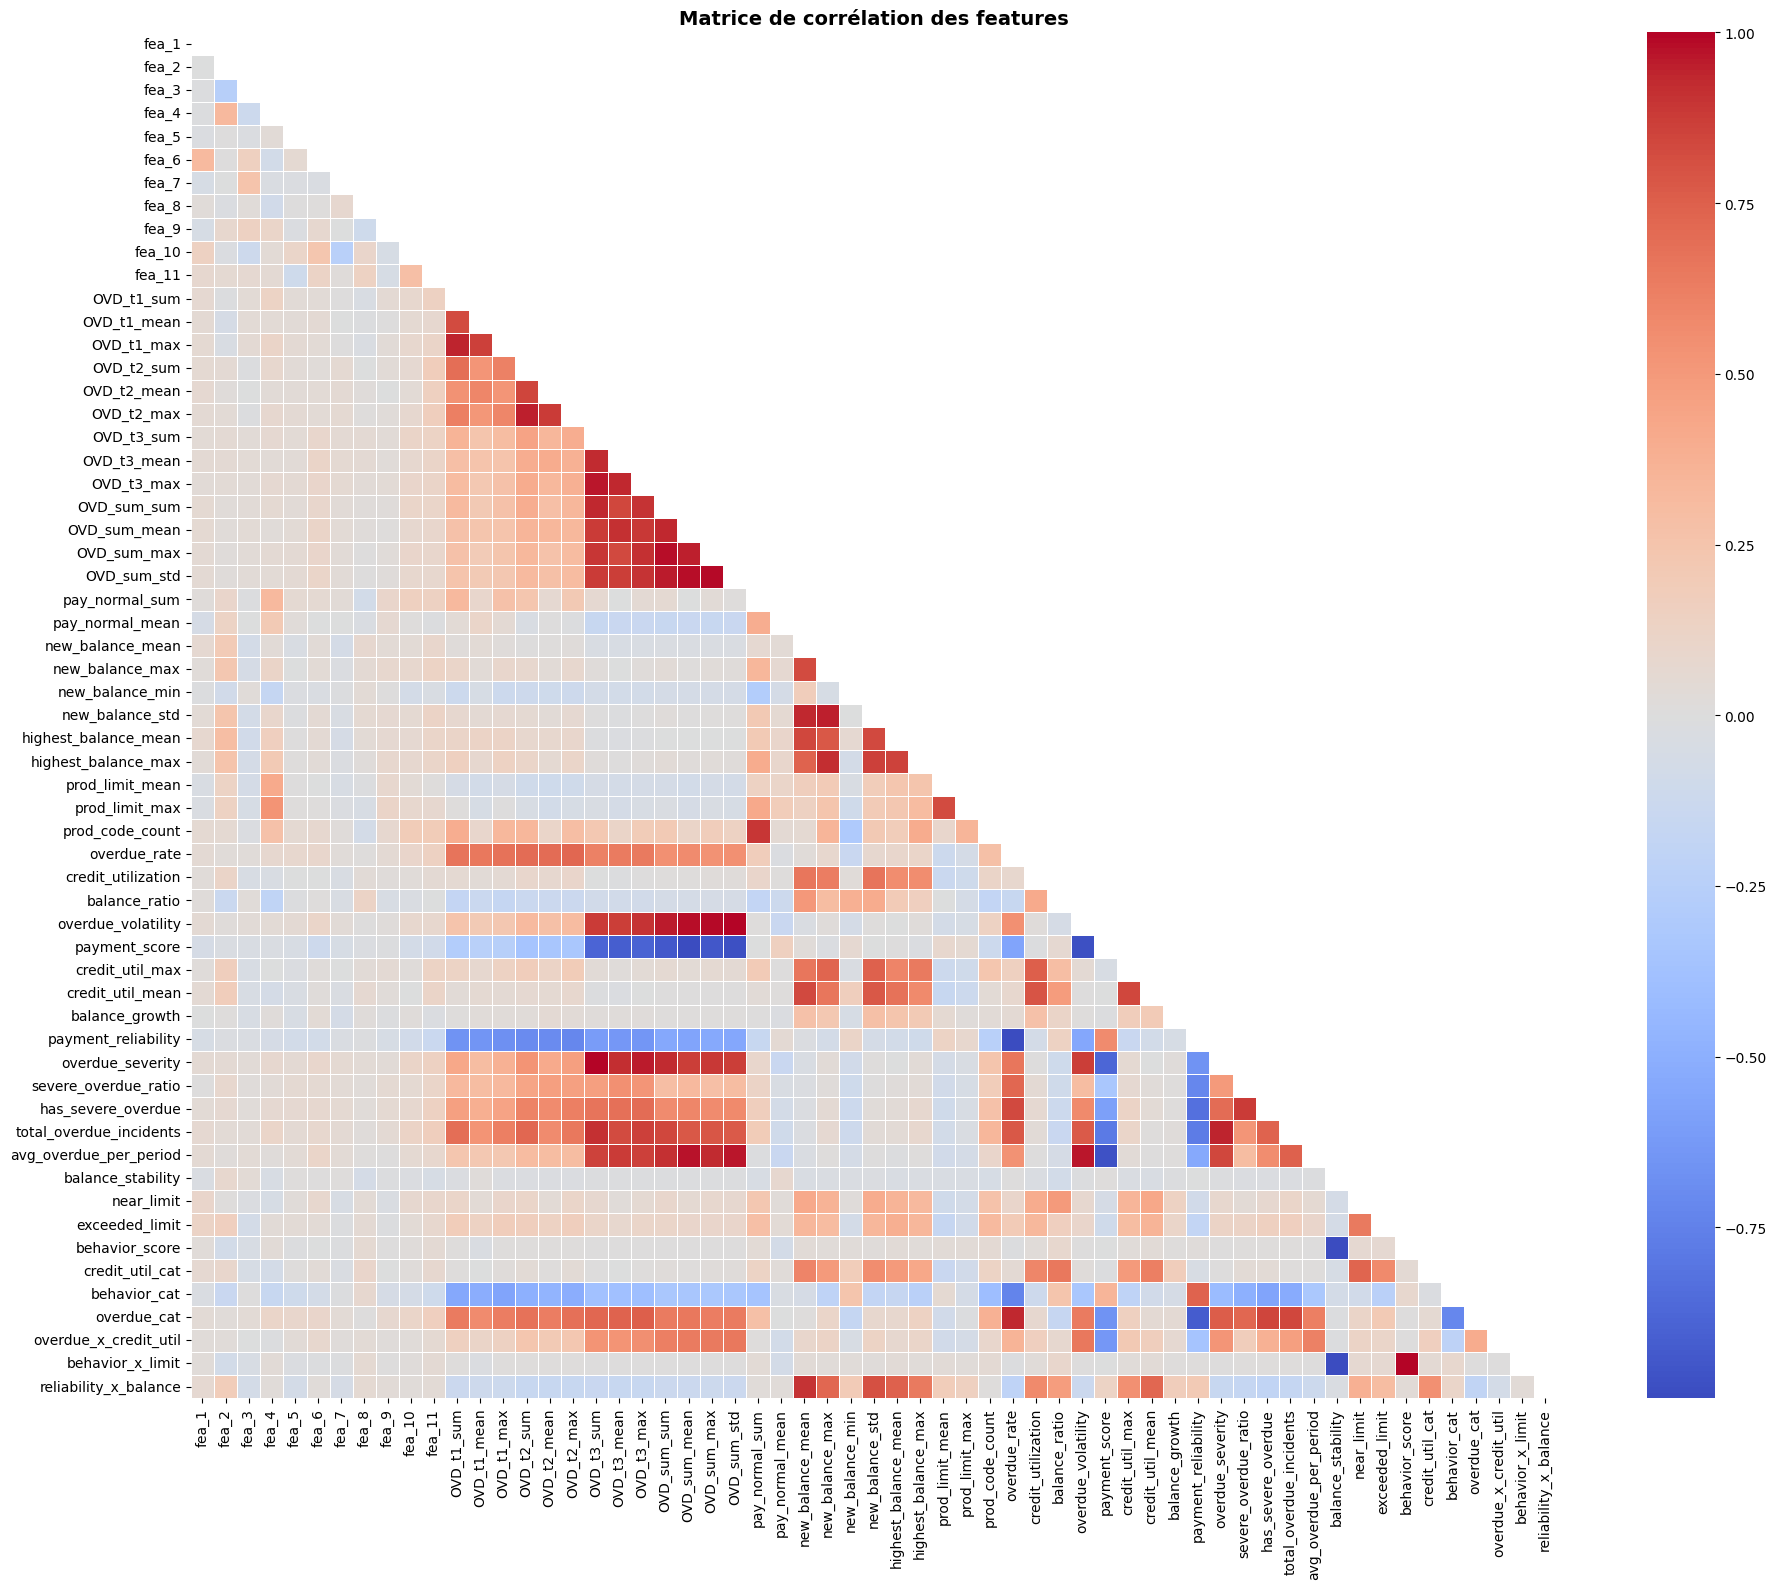

In [33]:
plt.figure(figsize=(20, 16))
corr_matrix = X_new.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, annot=False, fmt='.2f')
plt.title('Matrice de corrélation des features', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

Corrélation avec la target

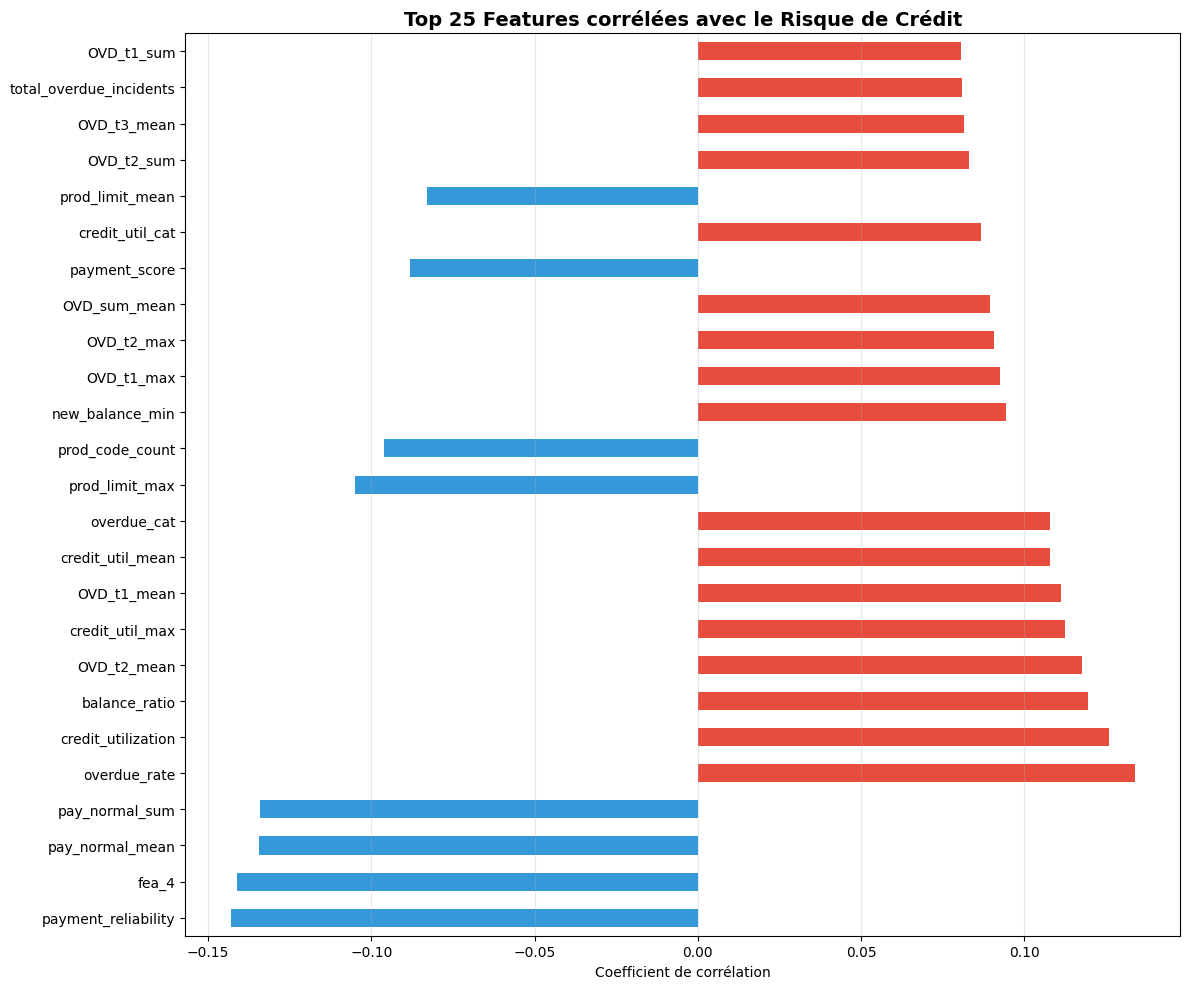

In [34]:
corr_with_target = df_feat[feature_cols_new + [target_col]].corr()[target_col].drop(target_col)
corr_with_target = corr_with_target.sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 10))
corr_with_target.head(25).plot(kind='barh', color=corr_with_target.head(25).apply(
    lambda x: '#e74c3c' if x > 0 else '#3498db'
))
plt.title('Top 25 Features corrélées avec le Risque de Crédit', fontsize=14, weight='bold')
plt.xlabel('Coefficient de corrélation')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



In [35]:
print(" Top 10 features (corrélation absolue):")
print(corr_with_target.head(10))

 Top 10 features (corrélation absolue):
payment_reliability   -0.143080
fea_4                 -0.141026
pay_normal_mean       -0.134294
pay_normal_sum        -0.133993
overdue_rate           0.133812
credit_utilization     0.126017
balance_ratio          0.119376
OVD_t2_mean            0.117531
credit_util_max        0.112296
OVD_t1_mean            0.111204
Name: label, dtype: float64


In [36]:
X_selection = df_feat[feature_cols_new]
y_selection = df_feat[target_col]

In [37]:
variance_selector = VarianceThreshold(threshold=0.01)
variance_selector.fit(X_selection)


VarianceThreshold(threshold=0.01)

In [38]:
low_variance_cols = X_selection.columns[~variance_selector.get_support()].tolist()
print(f" Features à faible variance supprimées: {len(low_variance_cols)}")
print(low_variance_cols)


 Features à faible variance supprimées: 1
['severe_overdue_ratio']


In [39]:
X_var = X_selection.loc[:, variance_selector.get_support()]
print(f" Features restantes après variance threshold: {X_var.shape[1]}")


 Features restantes après variance threshold: 58


In [60]:
def remove_highly_correlated(df, threshold=0.95):
    """Supprime les features avec corrélation > threshold"""
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]
    return df.drop(columns=to_drop), to_drop

X_uncorr, dropped_corr = remove_highly_correlated(X_var, threshold=1)
print(f"\n Features trop corrélées supprimées: {len(dropped_corr)}")
print(dropped_corr[:], "..." if len(dropped_corr) > 10 else "")
print(f" Features restantes: {X_uncorr.shape[1]}")



 Features trop corrélées supprimées: 0
[] 
 Features restantes: 58


MUTUAL INFORMATION


 Calcul du Mutual Information Score...


<Figure size 1200x1000 with 0 Axes>

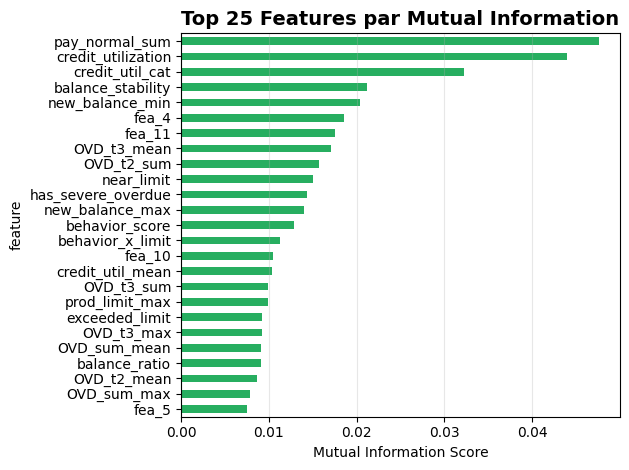

 Top 15 features (Mutual Information):
               feature  mi_score
24      pay_normal_sum  0.047612
36  credit_utilization  0.043963
52     credit_util_cat  0.032225
48   balance_stability  0.021230
28     new_balance_min  0.020385
3                fea_4  0.018585
10              fea_11  0.017571
18         OVD_t3_mean  0.017098
14          OVD_t2_sum  0.015750
49          near_limit  0.015062
45  has_severe_overdue  0.014396
27     new_balance_max  0.014001
51      behavior_score  0.012878
56    behavior_x_limit  0.011282
9               fea_10  0.010424


In [61]:
print("\n Calcul du Mutual Information Score...")

mi_scores = mutual_info_classif(X_uncorr, y_selection, random_state=42)
mi_df = pd.DataFrame({
    'feature': X_uncorr.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

plt.figure(figsize=(12, 10))
mi_df.head(25).plot(x='feature', y='mi_score', kind='barh', color='#27ae60', legend=False)
plt.title('Top 25 Features par Mutual Information', fontsize=14, weight='bold')
plt.xlabel('Mutual Information Score')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(" Top 15 features (Mutual Information):")
print(mi_df.head(15))

FEATURE IMPORTANCE

<Figure size 1200x1000 with 0 Axes>

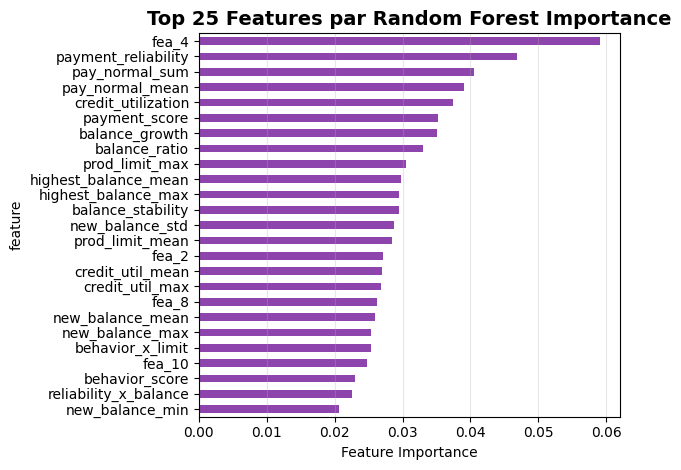

 Top 15 features (Random Forest):
                 feature  importance
3                  fea_4    0.059072
43   payment_reliability    0.046892
24        pay_normal_sum    0.040579
25       pay_normal_mean    0.038977
36    credit_utilization    0.037440
39         payment_score    0.035201
42        balance_growth    0.035006
37         balance_ratio    0.033067
33        prod_limit_max    0.030452
30  highest_balance_mean    0.029767
31   highest_balance_max    0.029480
48     balance_stability    0.029410
29       new_balance_std    0.028683
32       prod_limit_mean    0.028513
1                  fea_2    0.027158


In [62]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_uncorr, y_selection)

rf_importance = pd.DataFrame({
    'feature': X_uncorr.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
rf_importance.head(25).plot(x='feature', y='importance', kind='barh', color='#8e44ad', legend=False)
plt.title('Top 25 Features par Random Forest Importance', fontsize=14, weight='bold')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(" Top 15 features (Random Forest):")
print(rf_importance.head(15))

In [63]:
mi_df['mi_rank'] = range(1, len(mi_df) + 1)
rf_importance['rf_rank'] = range(1, len(rf_importance) + 1)

ranking_df = mi_df.merge(rf_importance, on='feature')
ranking_df['avg_rank'] = (ranking_df['mi_rank'] + ranking_df['rf_rank']) / 2
ranking_df = ranking_df.sort_values('avg_rank')


In [76]:
TOP_N_FEATURES = 58
selected_features = ranking_df.head(TOP_N_FEATURES)['feature'].tolist()


In [77]:
print(selected_features)


['pay_normal_sum', 'credit_utilization', 'fea_4', 'balance_stability', 'prod_limit_max', 'payment_reliability', 'new_balance_min', 'balance_ratio', 'credit_util_mean', 'new_balance_max', 'fea_11', 'behavior_x_limit', 'behavior_score', 'balance_growth', 'fea_10', 'highest_balance_mean', 'pay_normal_mean', 'fea_2', 'payment_score', 'new_balance_mean', 'credit_util_cat', 'prod_limit_mean', 'new_balance_std', 'OVD_sum_mean', 'OVD_t2_sum', 'credit_util_max', 'fea_7', 'OVD_t3_mean', 'overdue_x_credit_util', 'overdue_rate', 'OVD_sum_max', 'near_limit', 'highest_balance_max', 'OVD_t2_mean', 'fea_8', 'has_severe_overdue', 'exceeded_limit', 'overdue_volatility', 'OVD_t3_max', 'OVD_t1_mean', 'OVD_sum_std', 'OVD_t3_sum', 'fea_5', 'behavior_cat', 'OVD_sum_sum', 'prod_code_count', 'reliability_x_balance', 'fea_1', 'fea_6', 'fea_3', 'fea_9', 'OVD_t1_sum', 'overdue_cat', 'OVD_t1_max', 'avg_overdue_per_period', 'OVD_t2_max', 'overdue_severity', 'total_overdue_incidents']


<Figure size 1400x800 with 0 Axes>

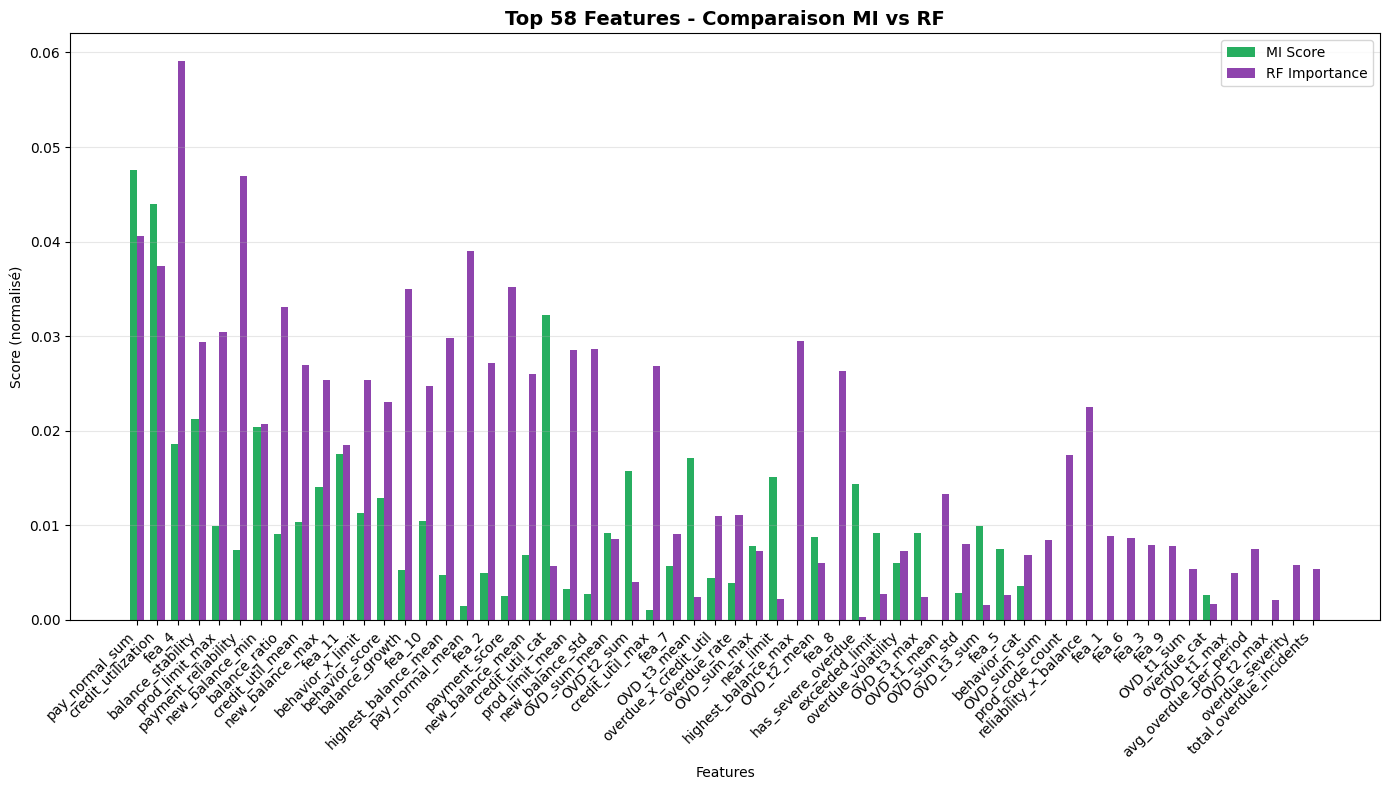

In [78]:
plt.figure(figsize=(14, 8))
ranking_df_top = ranking_df.head(TOP_N_FEATURES)

x = np.arange(len(ranking_df_top))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, ranking_df_top['mi_score'], width, label='MI Score', color='#27ae60')
bars2 = ax.bar(x + width/2, ranking_df_top['importance'], width, label='RF Importance', color='#8e44ad')

ax.set_xlabel('Features')
ax.set_ylabel('Score (normalisé)')
ax.set_title(f'Top {TOP_N_FEATURES} Features - Comparaison MI vs RF', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ranking_df_top['feature'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [79]:
X_final = df_feat[selected_features]
y_final = df_feat[target_col]

print(f" Dataset final: {X_final.shape[0]} lignes × {X_final.shape[1]} features")


 Dataset final: 1125 lignes × 58 features


In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    stratify=y_final,
    random_state=42
)

In [81]:
print(f" Train set: {X_train.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples")
print(f"\n Distribution dans train:")
print(y_train.value_counts(normalize=True))


 Train set: 900 samples
 Test set: 225 samples

 Distribution dans train:
label
0    0.8
1    0.2
Name: proportion, dtype: float64


In [82]:
preprocessing_pipeline = Pipeline([
    ('scaler', RobustScaler())
])

In [83]:
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)


In [84]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

X_train_scaled.head()


,pay_normal_sum,credit_utilization,fea_4,balance_stability,prod_limit_max,payment_reliability,new_balance_min,balance_ratio,credit_util_mean,new_balance_max,...,fea_6,fea_3,fea_9,OVD_t1_sum,overdue_cat,OVD_t1_max,avg_overdue_per_period,OVD_t2_max,overdue_severity,total_overdue_incidents
806,0.727273,2.221749,2.552239,1.002213,1.029626,-0.544995,-105.6,1.016766,1.691710,4.831150,...,1.333333,0.0,0.5,2.0,1.0,2.0,0.713012,0.0,0.666667,0.888889
290,-0.515152,0.000000,-0.014925,-0.066077,0.000000,-0.004907,-2682.0,-0.175761,-0.216607,-0.233881,...,1.333333,-1.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
667,0.050505,0.386885,0.701493,-0.694198,1.612433,0.089956,5889.6,0.912015,0.301486,0.348238,...,-1.000000,0.0,-0.5,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1110,-0.545455,-0.451554,-0.641791,-0.000578,-0.641088,-0.021982,0.0,-0.419231,-0.333776,-0.278738,...,1.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
337,-0.525253,1.101851,0.388060,-0.216284,-0.796503,-0.010177,0.0,0.333248,0.843196,0.380230,...,0.000000,-1.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [85]:
X_train_scaled.to_csv('X_train.csv', index=False)
X_test_scaled.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


Sauvegarder le pipeline et la liste des features

In [86]:
with open('preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)

with open('selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)
